In [36]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import statsmodels.api as sm

warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import json
import joblib

# Setting the working directory
# os.chdir(r'../')
if os.getcwd().endswith('notebook'):
    os.chdir(r'../')
print('current working directory:', os.getcwd())

# Pandas option:
pd.set_option('max_colwidth',40)  # This allows us to see the data upto 40 characters per each column

pd.options.display.max_columns = None   # This allows us to see all the columns without collapsing 


# The below code is for for showing all expressions, not just the result of the last expression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Table styles, this below code is for decorating the dataframe no functional use.
table_styles = {
        'cerulean_palette' : [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80"), ("text-transform", "capitalize")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")])
    ]
}

current working directory: f:\NTU Learn\DS Thinking\ntu_sd6101_team_project


In [2]:
modify_rate_df1 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/task1_negative_raw_with_results.csv', na_values=['-','',' ','NEW','[]'])
modify_rate_df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
modify_rate_df1 = modify_rate_df1[['id', 'rate','predicted_rate']]
modify_rate_df1['rate'] = modify_rate_df1['rate'].str.replace('/5', '').astype(float)
modify_rate_df2 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/task1_training_raw_attributes.csv')
modify_rate_df2.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
modify_rate_df2 = modify_rate_df2[['id', 'rate']]
modify_rate_df1.columns, modify_rate_df2.columns

(Index(['id', 'rate', 'predicted_rate'], dtype='object'),
 Index(['id', 'rate'], dtype='object'))

In [3]:
need_fill_index = modify_rate_df1[modify_rate_df1['rate'].isna()].index
no_need_fill_index = modify_rate_df1[~modify_rate_df1['rate'].isna()].index
modify_rate_df1.loc[need_fill_index, 'modified_rate'] = modify_rate_df1.loc[need_fill_index, 'predicted_rate']
modify_rate_df1.loc[no_need_fill_index, 'modified_rate'] = modify_rate_df1.loc[no_need_fill_index, :].apply(lambda row: (row['rate']*0.6 + row['predicted_rate']*0.4), axis=1)
modify_rate_df1.drop(columns=['rate', 'predicted_rate'], inplace=True)
modify_rate_df1.rename(columns={'modified_rate': 'rate'}, inplace=True)
modify_rate_df1.columns, modify_rate_df2.columns

(Index(['id', 'rate'], dtype='object'), Index(['id', 'rate'], dtype='object'))

In [4]:
rate_df = pd.concat([modify_rate_df1, modify_rate_df2], axis=0)
rate_df.sort_values(by='id', inplace=True)
rate_df.reset_index(drop=True, inplace=True)
rate_df.head()

,id,rate
0,0,3.475852
1,0,4.100000
2,1,4.100000
3,1,3.281422
4,2,3.491694


In [5]:
raw_zomato = pd.read_csv('../ntu_sd6101_team_project_data/new_zomato.csv')
raw_zomato.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
raw_zomato = raw_zomato.loc[:,['id', 'listed_in(city)','approx_cost_for_one_people']]
raw_zomato.rename(columns={'listed_in(city)': 'location','approx_cost_for_one_people':'PCC'}, inplace=True)
raw_zomato.head()

,id,location,PCC
0,0,Banashankari,400.0
1,1,Banashankari,400.0
2,2,Banashankari,400.0
3,3,Banashankari,150.0
4,4,Banashankari,300.0


In [6]:
pd.unique(raw_zomato['location'])

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

In [7]:
location_df = pd.read_csv('../ntu_sd6101_team_project_data/location_info.csv')
location_df = location_df.loc[:,['location', 'area_customer_flow']]
location_df.head()

,location,area_customer_flow
0,Banashankari,44565.1110
1,Bannerghatta Road,458971.6409
2,Basavanagudi,12716.7456
3,Bellandur,38891.1865
4,Brigade Road,615.0830


In [8]:
pd.unique(location_df['location'])

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

In [9]:
# CAR_df = pd.read_csv('../ntu_sd6101_team_project_data/task2_data/CAR_estimate.csv')
CAR_df = pd.read_csv('../ntu_sd6101_team_project_data/task2_data/CAR_estimate_GB.csv')
# CAR_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
CAR_df.rename(columns={'original_index': 'id'}, inplace=True)
CAR_df = CAR_df.loc[:,['id', 'predicted_value']]
CAR_df.rename(columns={'predicted_value': 'CAR'}, inplace=True)
CAR_df.head()

,id,CAR
0,4,0.52
1,34,0.56
2,40,0.86
3,62,0.60
4,80,0.68


In [10]:
final_df = pd.merge(raw_zomato, location_df, on='location', how='left')
final_df = pd.merge(final_df, CAR_df, on='id', how='left')
final_df = pd.merge(final_df, rate_df, on='id', how='left')
final_df.head()

,id,location,PCC,area_customer_flow,CAR,rate
0,0,Banashankari,400.0,44565.111,0.58,3.475852
1,0,Banashankari,400.0,44565.111,0.58,4.100000
2,1,Banashankari,400.0,44565.111,0.60,4.100000
3,1,Banashankari,400.0,44565.111,0.60,3.281422
4,2,Banashankari,400.0,44565.111,0.55,3.491694


In [11]:
# use group mean to fill missing values
final_df['CAR'].fillna(final_df.groupby('location')['CAR'].transform('mean'), inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36112\1778744482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['CAR'].fillna(final_df.groupby('location')['CAR'].transform('mean'), inplace=True)


In [12]:
final_df['location_CAR_sum'] = final_df.groupby('location')['CAR'].transform('sum')
final_df['CAR_each_restaurant'] = final_df['CAR'] / final_df['location_CAR_sum']
final_df.drop(columns=['location_CAR_sum'], inplace=True)
final_df['customer_each_restaurant'] = np.ceil(final_df['CAR_each_restaurant'] * final_df['area_customer_flow'])
final_df['DNI'] = final_df['customer_each_restaurant'] * final_df['PCC']
final_df.head()

,id,location,PCC,area_customer_flow,CAR,rate,CAR_each_restaurant,customer_each_restaurant,DNI
0,0,Banashankari,400.0,44565.111,0.58,3.475852,0.000608,28.0,11200.0
1,0,Banashankari,400.0,44565.111,0.58,4.100000,0.000608,28.0,11200.0
2,1,Banashankari,400.0,44565.111,0.60,4.100000,0.000629,29.0,11600.0
3,1,Banashankari,400.0,44565.111,0.60,3.281422,0.000629,29.0,11600.0
4,2,Banashankari,400.0,44565.111,0.55,3.491694,0.000577,26.0,10400.0


In [13]:
final_df.to_csv('../ntu_sd6101_team_project_data/task3_data/DNI_estimate.csv', index=False)

### Visualization

In [14]:
final_df[final_df['DNI']==final_df['DNI'].min()]

,id,location,PCC,area_customer_flow,CAR,rate,CAR_each_restaurant,customer_each_restaurant,DNI
5732,5270,Brigade Road,20.0,615.0830,0.64,3.288741,0.000362,1.0,20.0
5733,5270,Brigade Road,20.0,615.0830,0.64,3.700000,0.000362,1.0,20.0
27287,27091,Koramangala 4th Block,20.0,1608.5897,0.65,3.600000,0.000316,1.0,20.0
30281,32485,Koramangala 6th Block,20.0,1530.9422,0.65,3.900000,0.000375,1.0,20.0


In [15]:
final_df['DNI'].describe()

count     76692.000000
mean       3596.168249
std        8715.821812
min          20.000000
25%         350.000000
50%        1000.000000
75%        2800.000000
max      148000.000000
Name: DNI, dtype: float64

<Axes: xlabel='DNI', ylabel='Density'>

Text(0.5, 1.0, 'DNI Distribution')

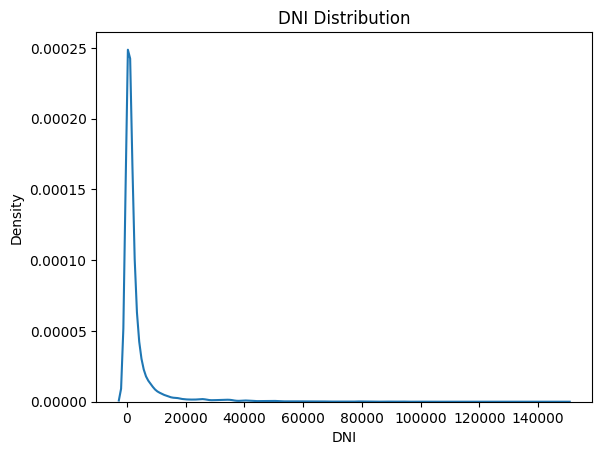

In [44]:
sns.kdeplot(final_df['DNI'])
plt.title('DNI Distribution')

<Axes: xlabel='CAR', ylabel='Density'>

Text(0.5, 1.0, 'CAR Distribution')

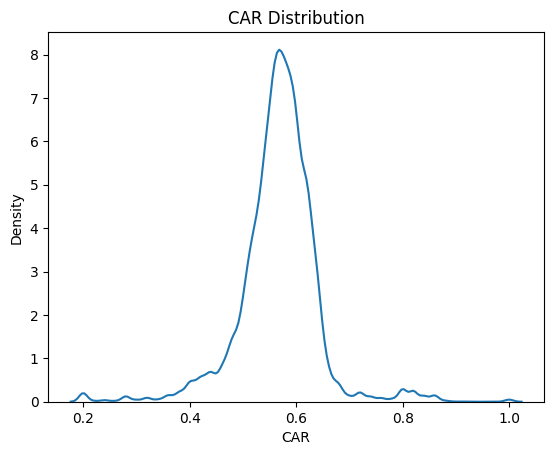

In [45]:
sns.kdeplot(final_df['CAR'])
plt.title('CAR Distribution')

In [18]:
final_df['log_DNI'] = np.log(final_df['DNI'])

<Figure size 1000x1000 with 0 Axes>

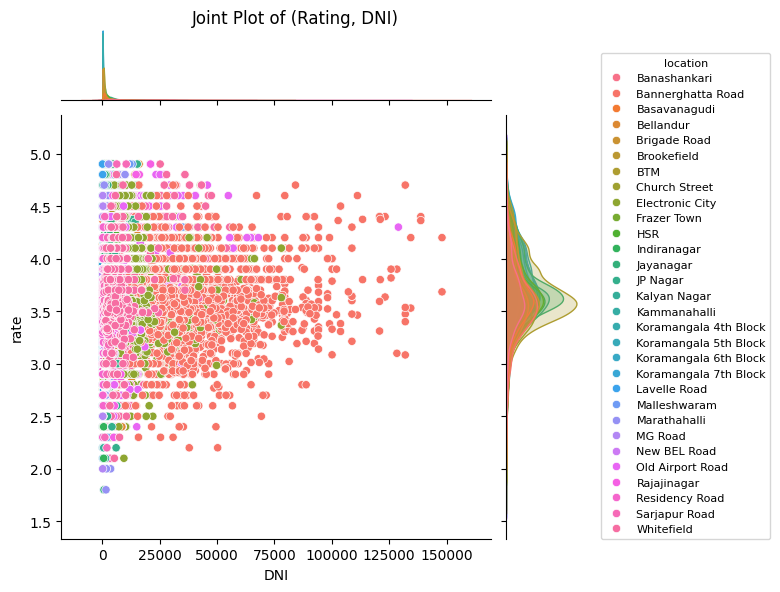

In [28]:
plt.figure(figsize=(10, 10))
joint_plot = sns.jointplot(x='DNI', y='rate', data=final_df, hue='location')

joint_plot.fig.suptitle('Joint Plot of (Rating, DNI)', fontsize=12)

joint_plot.fig.subplots_adjust(top=0.95)

plt.legend(loc='lower right', fontsize=8, title='location', title_fontsize=8, bbox_to_anchor=(1.65, 0.0), borderaxespad=0)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36112\2235679053.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='location', y='DNI', data=final_df[final_df['location'].isin(best_10_location)], palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Banashankari'),
  Text(1, 0, 'Bannerghatta Road'),
  Text(2, 0, 'Bellandur'),
  Text(3, 0, 'Electronic City'),
  Text(4, 0, 'HSR'),
  Text(5, 0, 'Jayanagar'),
  Text(6, 0, 'JP Nagar'),
  Text(7, 0, 'Old Airport Road'),
  Text(8, 0, 'Rajajinagar'),
  Text(9, 0, 'Whitefield')])

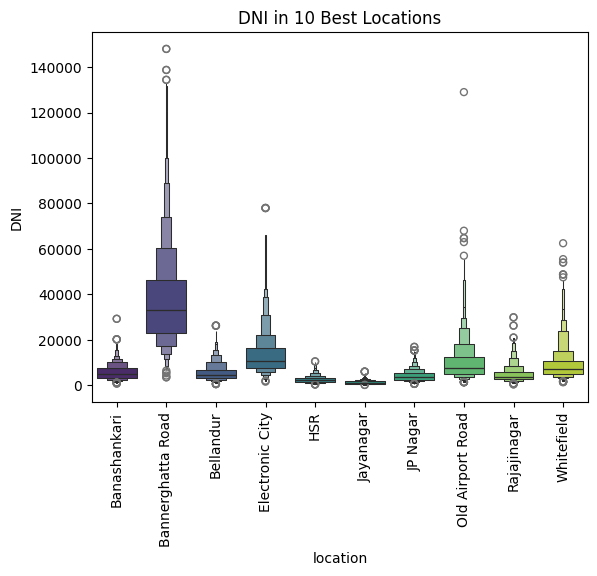

In [29]:
best_10_location = final_df.groupby('location')['DNI'].sum().sort_values(ascending=False).head(10).index
sns.boxenplot(x='location', y='DNI', data=final_df[final_df['location'].isin(best_10_location)], palette='viridis')
plt.title('DNI in 10 Best Locations')
plt.xticks(rotation=90)

In [30]:
final_df.head()

,id,location,PCC,area_customer_flow,CAR,rate,CAR_each_restaurant,customer_each_restaurant,DNI,log_DNI
0,0,Banashankari,400.0,44565.111,0.58,3.475852,0.000608,28.0,11200.0,9.323669
1,0,Banashankari,400.0,44565.111,0.58,4.100000,0.000608,28.0,11200.0,9.323669
2,1,Banashankari,400.0,44565.111,0.60,4.100000,0.000629,29.0,11600.0,9.358760
3,1,Banashankari,400.0,44565.111,0.60,3.281422,0.000629,29.0,11600.0,9.358760
4,2,Banashankari,400.0,44565.111,0.55,3.491694,0.000577,26.0,10400.0,9.249561


In [38]:
import statsmodels.api as sm

X1 = final_df.loc[:,['rate', 'PCC', 'area_customer_flow']]
y1 = final_df['log_DNI']

X1 = sm.add_constant(X1)
ols_model_1 = sm.OLS(y1, X1)
ols_results_1 = ols_model_1.fit()

print(ols_results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_DNI   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                 2.573e+04
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:10:05   Log-Likelihood:            -1.1149e+05
No. Observations:               76692   AIC:                         2.230e+05
Df Residuals:                   76688   BIC:                         2.230e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.6863      0

In [42]:
robust_model = sm.RLM(y1, X1, M=sm.robust.norms.HuberT())
robust_results = robust_model.fit()

print(robust_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                log_DNI   No. Observations:                76692
Model:                            RLM   Df Residuals:                    76688
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Nov 2024                                         
Time:                        00:11:19                                         
No. Iterations:                    14                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.7204      0

In [41]:
glm_model = sm.GLM(y1, X1, family=sm.families.Gaussian())
glm_results_1 = glm_model.fit()

print(glm_results_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                log_DNI   No. Observations:                76692
Model:                            GLM   Df Residuals:                    76688
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1.0722
Method:                          IRLS   Log-Likelihood:            -1.1149e+05
Date:                Mon, 11 Nov 2024   Deviance:                       82224.
Time:                        00:11:09   Pearson chi2:                 8.22e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6346
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.6863      0

In [39]:
# 1. Function for Coefficient Plot with 95% CI
def plot_coefficient_plot(model_results, X_data):
    conf_int = model_results.conf_int()
    coef_df = pd.DataFrame({
        'coef': model_results.params[1:],  # Exclude constant
        'var': X_data.columns[1:],  # Exclude constant
        'ci_lower': conf_int.iloc[1:, 0],
        'ci_upper': conf_int.iloc[1:, 1]
    })
    plt.errorbar(x=range(len(coef_df)), 
                 y=coef_df['coef'], 
                 yerr=[coef_df['coef'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coef']], 
                 fmt='o')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
    plt.xticks(range(len(coef_df)), coef_df['var'], rotation=45)
    plt.title('Coefficient Plot with 95% CI')

# 2. Function for Residuals vs Fitted Plot
def plot_residuals_vs_fitted(model_results, X_data, y_data):
    fitted_values = model_results.fittedvalues
    residuals = model_results.resid
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')

# 3. Function for Normal Q-Q Plot
def plot_qq_plot(model_results):
    sm.qqplot(model_results.resid, line='45')
    plt.title('Normal Q-Q Plot')

# 4. Function for Residuals Distribution Plot
def plot_residuals_distribution(model_results):
    sns.histplot(model_results.resid, kde=True)
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution')

# 5. Function for Scale-Location Plot
def plot_scale_location(model_results, X_data, y_data):
    fitted_values = model_results.fittedvalues
    standardized_residuals = np.sqrt(np.abs(stats.zscore(model_results.resid)))
    plt.scatter(fitted_values, standardized_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Fitted Values')
    plt.ylabel(r'Sqrt(|Standardized Residuals|)')
    plt.title('Scale-Location Plot')

# 6. Function for Actual vs Predicted Plot
def plot_actual_vs_predicted(model_results, y_data):
    fitted_values = model_results.fittedvalues
    plt.scatter(y_data, fitted_values, alpha=0.5)
    plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--', lw=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')

# Main function to combine all plots
def plot_regression_results(model_results, X_data, y_data, figsize=(15, 10)):
    """
    Visualize regression results with multiple plots
    
    Parameters:
    -----------
    model_results : statsmodels regression results object
    X_data : DataFrame of features
    y_data : Series of target variable
    figsize : tuple, optional (default=(15, 10))
        Figure size
    """
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. Coefficient Plot
    plt.subplot(231)
    conf_int = model_results.conf_int()
    coef_df = pd.DataFrame({
        'coef': model_results.params[1:],  # Exclude constant
        'var': X_data.columns[1:],  # Exclude constant
        'ci_lower': conf_int.iloc[1:, 0],
        'ci_upper': conf_int.iloc[1:, 1]
    })
    
    plt.errorbar(x=range(len(coef_df)), 
                y=coef_df['coef'],
                yerr=[coef_df['coef'] - coef_df['ci_lower'], 
                      coef_df['ci_upper'] - coef_df['coef']],
                fmt='o', capsize=5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.xticks(range(len(coef_df)), coef_df['var'], rotation=45)
    plt.title('Coefficient Plot with 95% CI')
    plt.grid(True, alpha=0.3)
    
    # 2. Residuals vs Fitted
    plt.subplot(232)
    fitted_vals = model_results.fittedvalues
    residuals = model_results.resid
    plt.scatter(fitted_vals, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.grid(True, alpha=0.3)
    
    # 3. QQ Plot
    plt.subplot(233)
    fig = stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Residuals Distribution
    plt.subplot(234)
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    
    # 5. Scale-Location Plot
    plt.subplot(235)
    std_resid = residuals / np.std(residuals)
    plt.scatter(fitted_vals, np.sqrt(np.abs(std_resid)), alpha=0.5)
    plt.xlabel('Fitted Values')
    plt.ylabel('Sqrt(|Standardized Residuals|)')
    plt.title('Scale-Location Plot')
    plt.grid(True, alpha=0.3)
    
    # 6. Actual vs Predicted
    plt.subplot(236)
    plt.scatter(y_data, fitted_vals, alpha=0.5)
    min_val = min(min(y_data), min(fitted_vals))
    max_val = max(max(y_data), max(fitted_vals))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

((array([-4.28741984, -4.08605703, -3.97643941, ...,  3.97643941,
          4.08605703,  4.28741984]),
  array([-4.02967472, -3.87887918, -3.28968264, ...,  2.56083372,
          2.58278922,  2.59245091])),
 (np.float64(1.0197653246320675),
  np.float64(-8.38034983893787e-13),
  np.float64(0.9848062674952013)))

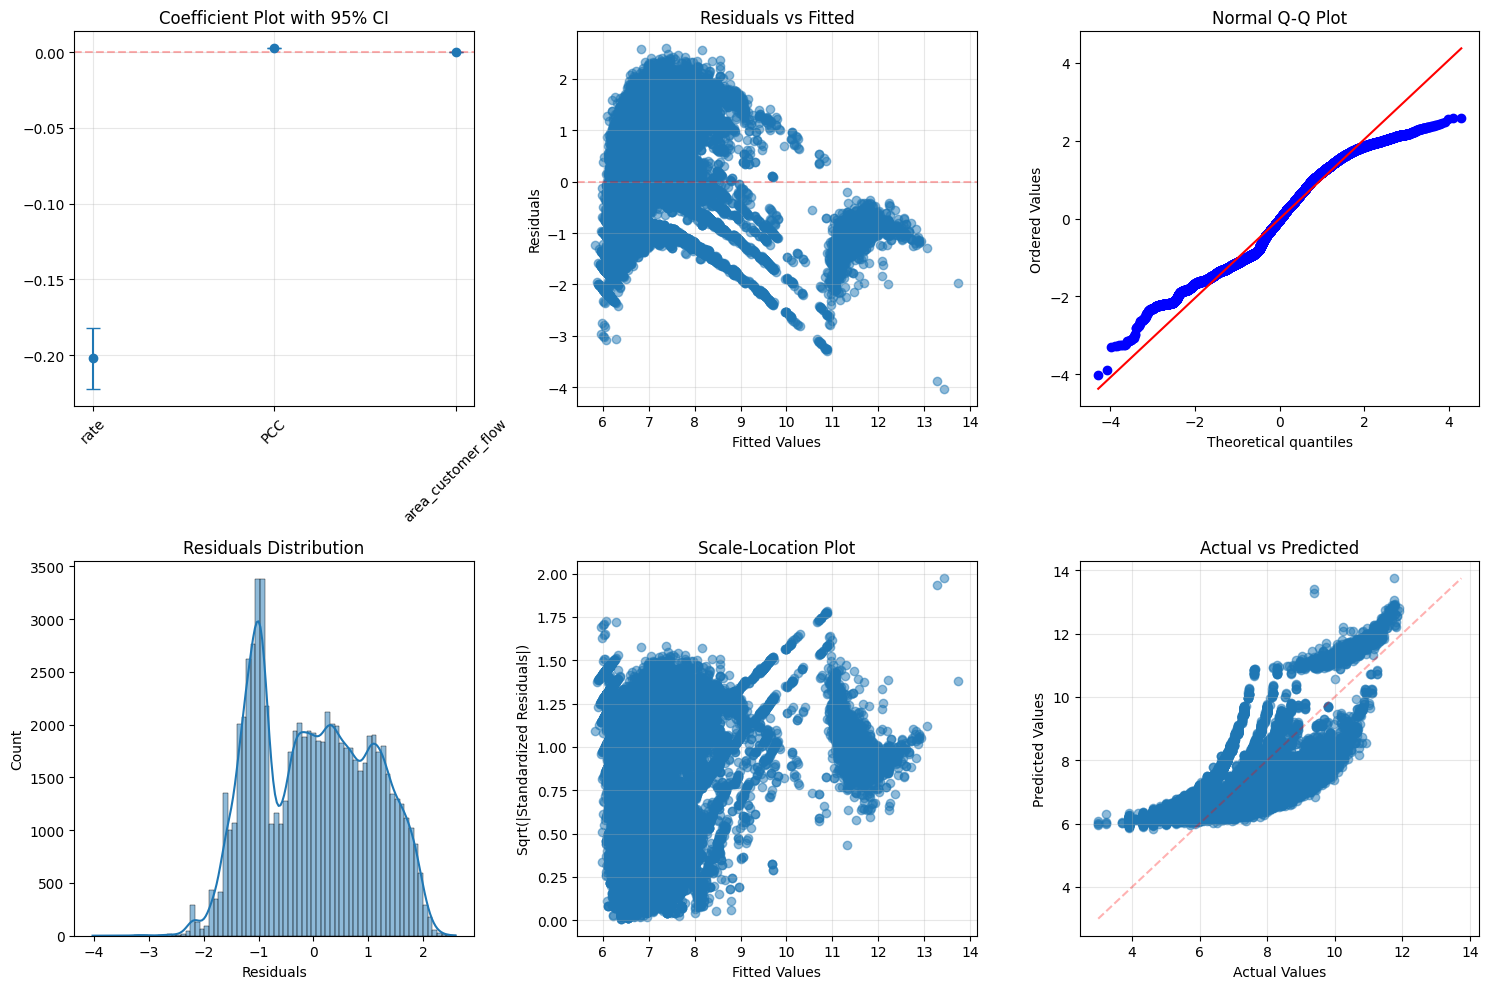

In [40]:
plot_regression_results(ols_results_1, X1, y1)

((array([-4.28741984, -4.08605703, -3.97643941, ...,  3.97643941,
          4.08605703,  4.28741984]),
  array([-4.12435127, -3.96496211, -3.35235596, ...,  2.55629913,
          2.59689495,  2.59819214])),
 (np.float64(1.0197983091109952),
  np.float64(-0.00040019574764187945),
  np.float64(0.9848105664569626)))

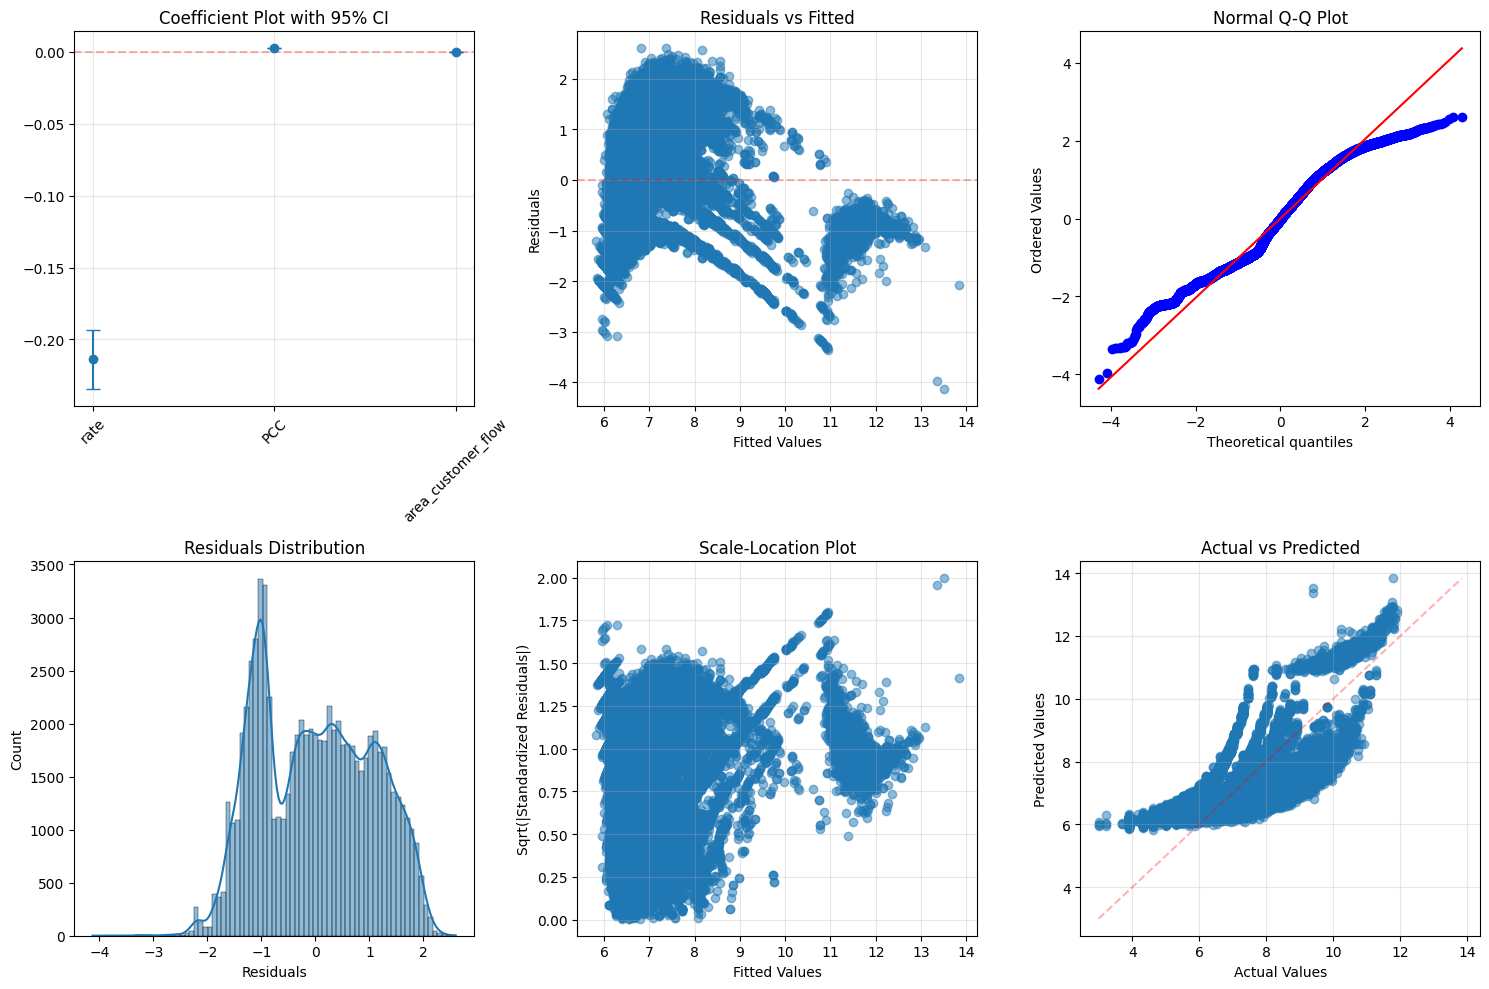

In [43]:
plot_regression_results(robust_results, X1, y1)